In [6]:
import pandas as pd
import spacy
from spacy.matcher import Matcher
from spacy.tokens import Span
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize
from bs4 import BeautifulSoup
import re

import networkx as nx

import glob
import string

import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [11]:
tweet_files = [] #glob.glob('../Data/Tweets_scraped_2000_*.csv')
news_files = glob.glob('../Data/corona_news_scraped_on_1*April*.csv')

In [12]:
print('\n'.join('Tweet File {}: {}'.format(*k) for k in enumerate(tweet_files)))

In [13]:
print('\n'.join('News File {}: {}'.format(*k) for k in enumerate(news_files)))

News File 0: ../Data\corona_news_scraped_on_1st_April.csv


In [14]:
all_news = pd.concat([pd.read_csv(f) for f in news_files],ignore_index =True)
all_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 317 entries, 0 to 316
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  317 non-null    object
 1   text      317 non-null    object
dtypes: object(2)
memory usage: 5.1+ KB


In [16]:
# all_tweets = pd.concat([pd.read_csv(f) for f in tweet_files],ignore_index =True)
# all_tweets.info()

In [18]:
# all_tweets.drop(columns=['geo','tweet','user_handle','location'],axis = 1,inplace=True)
# all_tweets.rename(columns={'cleaned_tweets':'text'},inplace=True)
# all_tweets.head()

In [19]:
# documents = pd.DataFrame()
# documents['text'] = pd.concat([all_news.text,all_tweets.text],axis =0 ,ignore_index=True)
# documents.head()

In [9]:
# documents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6658 entries, 0 to 6657
Data columns (total 1 columns):
text    6653 non-null object
dtypes: object(1)
memory usage: 52.1+ KB


In [10]:
# documents = documents.sample(frac=1).reset_index(drop=True)

In [11]:
# documents.head()

,text
0,i sincerely hope the uk public unite boycott ...
1,Imagine if doctors or nurses withheld their s...
2,Garrett Fedl govt is blocking shipments from ...
3,langer today we discharged our th patient fro...
4,peloton races berocca doses calling fans how e...


In [20]:
documents = pd.DataFrame()
documents['text'] = all_news.text

In [21]:
nlp = spacy.load('en_core_web_sm')

### Cleaning Data for NLP

In [22]:
# Remove HTML Tags
def remove_html(text):
    soup = BeautifulSoup(text,'lxml')
    html_free_text = soup.get_text()
    return html_free_text

# Remove Punctuations
def punctuation_remover(text):
    punctuation_free_text = " ".join([word for word in text if word \
                                    not in string.punctuation])
    return punctuation_free_text


# Stop Word Removal
cached_stop_words = stopwords.words('english') # Provides 70 X Speedup
def stop_words_remover(text):
#     text = text.lower().split()
    words = [word for word in text if \
             word not in cached_stop_words]
    return words

# Convert to lower case
def convert_to_lowercase(tokens):
    low = []
    for tok in tokens:
        low.append(tok.lower().strip())
    return low

# Lemmatization
def lemmatize_words(text):
    words = nlp(str(text))
    return [word.lemma_ for word in words if word.lemma_ != '-PRON-']  

def replace_urls(tokens):
    re.sub(r'''(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'".,<>?«»“”‘’]))''', " ", tokens)
    return tokens


def remove_short_strings(text, length):
    array = []
    for word in text:
        if len(word) > length:
            array.append(word)
    return array

In [23]:
tokenized_documents = documents.copy()
tokenized_documents['text'] = tokenized_documents.text.astype(str)

In [24]:
def clean_text_for_tasks(text, for_pos_tagging = False):
    cleaned_text = remove_html(text)
    cleaned_text = replace_urls(cleaned_text)
    cleaned_text = word_tokenize(cleaned_text)
   
    
    if for_pos_tagging is False:
        cleaned_text = convert_to_lowercase(cleaned_text)
        cleaned_text = stop_words_remover(cleaned_text)
        cleaned_text = lemmatize_words(cleaned_text)
    cleaned_text = remove_short_strings(cleaned_text,2)
    cleaned_text = punctuation_remover(cleaned_text)
    
    return cleaned_text

In [25]:
from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

tokenized_documents['cleaned_text'] = tokenized_documents.text.progress_apply(clean_text_for_tasks)
# tokenized_documents['cleaned_text'] = tokenized_documents.text.parallel_apply(clean_text_for_tasks,axis = 1 )

In [26]:
tokenized_documents.head()

,text,cleaned_text
0,SC seeks Centre's response in a week on a Nagp...,seek centre response week nagpur base doctor p...
1,Coronavirus can travel up to 8 metres from exh...,coronavirus travel metre exhalation linger air...
2,Man allegedly committed suicide in Madurai be...,man allegedly commit suicide madurai neighbour...
3,According to crime branch sources they have al...,accord crime branch source already identify pe...
4,The interim test report of the 2nd covid +ve p...,interim test report 2nd covid patient mecca re...


### Using Linguistic Features such as Named Entity Recognition and Parts-of-Speech

We will use these features to gain more insights into the most talked about entities. Which will allow us 
to further explore into those topics.

In [27]:
tokenized_documents[200:300].head(10)

,text,cleaned_text
200,Of those who attended the Nizamuddin gathering...,attend nizamuddin gathering 441 people admit h...
201,"We are going to set up more than 2,700 food ce...","set 2,700 food centre feed lakh people daily c..."
202,Govt wrote to Lieutenant Governor for registra...,govt write lieutenant governor registration fi...
203,441 from Delhi mosque taken to hospitals with ...,441 delhi mosque take hospital coronavirus sym...
204,ER workshop in West Bengal modifying sleeper c...,workshop west bengal modify sleeper coach 28-b...
205,41 have travel history to foreign countries an...,travel history foreign country family member f...
206,"Out of the 97 cases in Delhi, 24 cases are fro...",case delhi case markaz nizamuddin arvind kejriwal
207,First Covid-19 positive case in JharkhandA Mal...,first covid-19 positive case jharkhanda malays...
208,Xiaomi will donate Rs 10 crore to the PM's rel...,xiaomi donate crore relief fund relief fund ac...
209,Coal India Limited has committed Rs 220 crore ...,coal india limited commit 220 crore nlc india ...


In [28]:
from spacy import displacy

doc_1 = nlp(tokenized_documents.iloc[207].text)
displacy.render(doc_1, style="ent")

In [31]:
doc_1 = nlp(tokenized_documents.iloc[300].text)
displacy.render(doc_1, style="ent")

#### We can see that spacy does not recognize the Corona Virus 

In [32]:
# sample_texts = tokenized_documents[200:300].text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))
# sample_texts = tokenized_documents[200:300].cleaned_text
training_sample_data = tokenized_documents.sample(10,random_state=10)
for  text in training_sample_data.text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


#### We will retrain the model to detect few of these entities

In [33]:
#To-DO

In [34]:
# from spacy.symbols import nsubj, VERB,NORP, NOUN, PRON

# verbs = set()
# for possible_subject in test_doc:
#     if possible_subject.dep == nsubj and possible_subject.head.pos == VERB:
#         verbs.add(possible_subject.head)
# print(verbs)

In [35]:
# from spacy import displacy
# displacy.render(test_doc, style="ent")

### Find POS tags for each document like NOUN and PROPN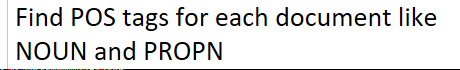

In [36]:
docs_for_pos = tokenized_documents.copy()
docs_for_pos['cleaned_for_pos_tagging'] = tokenized_documents.text.apply(lambda x : clean_text_for_tasks(x ,for_pos_tagging=True))   

In [37]:
def get_pos_tags():

    INTERTESTED_POS_TAGS = ['NOUN' , 'PROPN' ]
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows(),total = len(docs_for_pos)):
        pos= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
    #     tokenized = nlp(text)
        for token in tokenized:
            if token.pos_ in INTERTESTED_POS_TAGS:
    #                 print(token.text,token.pos_)
                pos['word'] = token.text
                pos['pos_tag'] = token.pos_
                tags.append(pos)
    return tags

In [38]:
# from joblib import Parallel, delayed
# tags = Parallel(n_jobs=8,backend='multiprocessing')(
#             delayed(get_pos_tags())
# #         )
# from pandarallel import pandarallel
# pandarallel.initialize(progress_bar=True)

# tags = docs_for_pos.parallel_apply(get_pos_tags,axis =1 )
tags = get_pos_tags()

In [39]:
tags_df = pd.DataFrame(tags)
tags_df.head()

,word,pos_tag
0,workers,NOUN
1,workers,NOUN
2,workers,NOUN
3,workers,NOUN
4,workers,NOUN


In [40]:
tags_size = tags_df.groupby(['pos_tag', 'word']).size()

In [41]:
tags_noun = tags_df.loc[tags_df.pos_tag == 'NOUN']
tags_noun.head()

,word,pos_tag
0,workers,NOUN
1,workers,NOUN
2,workers,NOUN
3,workers,NOUN
4,workers,NOUN


In [42]:
from pandas.core.common import flatten

all_noun_words =list(flatten(tags_df.word.values))

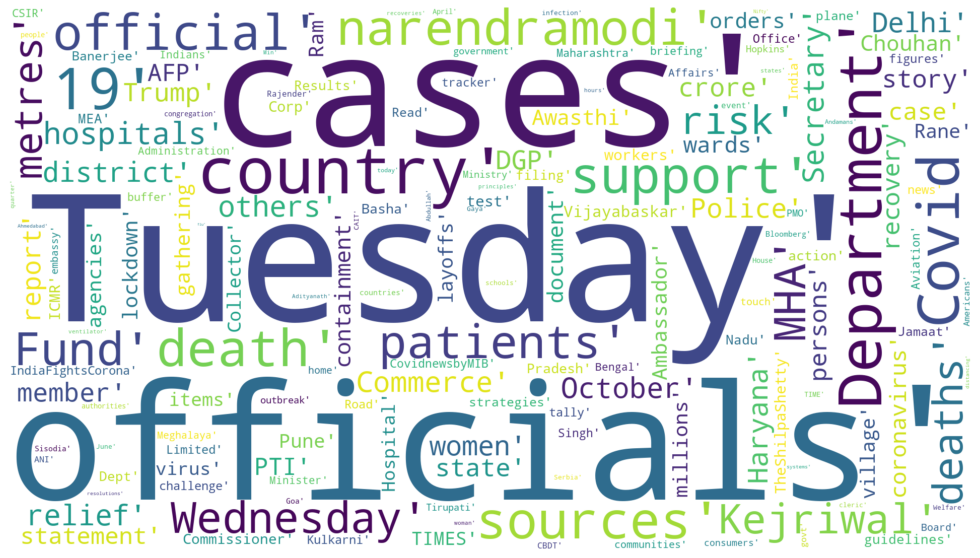

In [43]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

def generate_word_cloud(words):
    wordcloud = WordCloud(background_color = 'white',collocations=False,width=1920, height=1080).generate(str(words))
    plt.figure(figsize= (20,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

generate_word_cloud(all_noun_words)  

In [44]:
from collections import Counter

noun_counts = Counter(tags_df.word)

In [45]:
print(noun_counts.most_common(30))

[('Tuesday', 233), ('cases', 185), ('officials', 165), ('country', 148), ('Department', 127), ('death', 89), ('support', 88), ('narendramodi', 83), ('patients', 77), ('Covid-19', 71), ('MHA', 68), ('Wednesday', 67), ('deaths', 62), ('Kejriwal', 61), ('metres', 58), ('Fund', 58), ('risk', 55), ('hospitals', 54), ('official', 51), ('Secretary', 50), ('relief', 49), ('others', 49), ('Commerce', 48), ('October', 48), ('COVID-19', 47), ('sources', 47), ('district', 47), ('Haryana', 47), ('women', 46), ('Delhi', 46)]


In [46]:
most_common_nouns = noun_counts.most_common(40)
for i in range(3):
    most_common_nouns.pop(0)

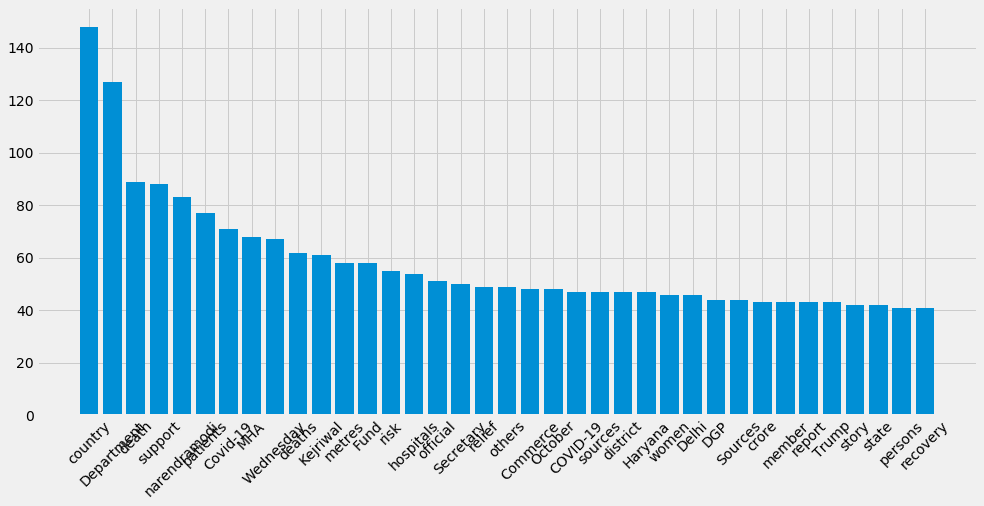

In [47]:
plt.style.use('fivethirtyeight')
# plt.title('Most Commonly Used NOUNs')
plt.figure(figsize=(15,7))
plt.xticks(rotation='45')
plt.bar(*zip(*most_common_nouns))
plt.show()


### Now, let us find the most common occuring Entities

In [48]:
def get_entity_tags():

    INTERTESTED_ENTITY_TAGS = ['NORP' , 'GPE' ,'ORG', 'PRODUCT', 'LOC', 'PERSON']
    tags = []
    for index,sentence in tqdm_notebook(docs_for_pos.iterrows(),total = len(docs_for_pos)):
        entity= {}
        tokenized = nlp(sentence.cleaned_for_pos_tagging)
        for ent in tokenized.ents:
            if ent.label_ in INTERTESTED_ENTITY_TAGS:
                entity['word'] = ent.text
                entity['entity_tag'] = ent.label_
                tags.append(entity)
    return tags

In [49]:
entities = get_entity_tags()

In [50]:
# entities

In [51]:
entities_df = pd.DataFrame(entities)

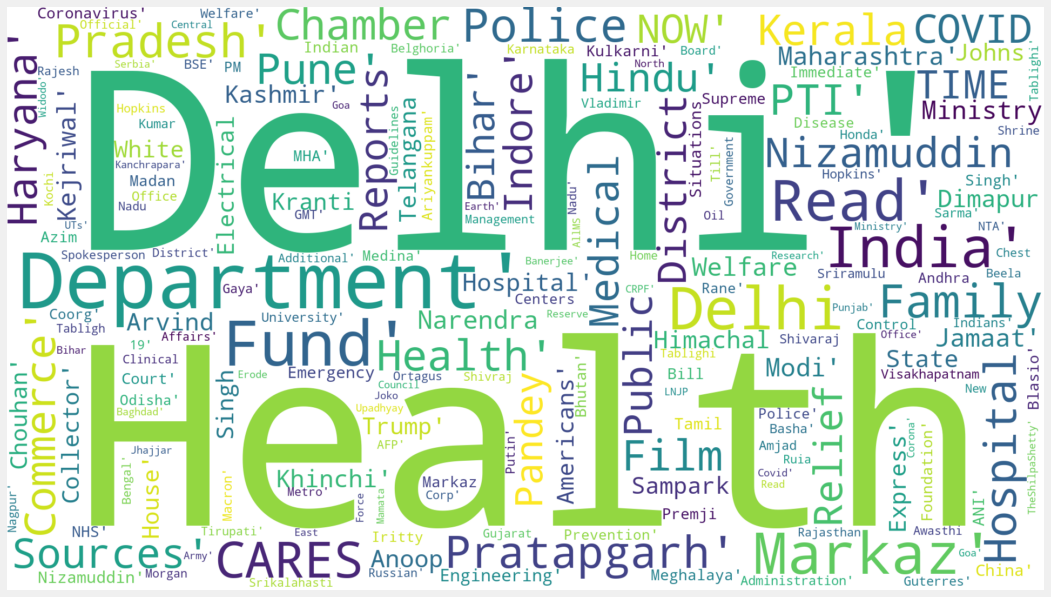

In [52]:
all_entities =list(flatten(entities_df.word.values))
generate_word_cloud(all_entities)  

In [53]:
entity_counts = Counter(entities_df.word)

In [54]:
entity_counts.most_common(30)

[('Delhi', 42),
 ('Read', 25),
 ('India', 24),
 ('Markaz', 20),
 ('Pratapgarh', 15),
 ('Kerala Film Chamber Commerce', 14),
 ('Pune', 14),
 ('PTI', 14),
 ('Delhi Police Sources', 13),
 ('Haryana', 13),
 ('Hindu', 12),
 ('Indore', 12),
 ('Pandey Bihar', 11),
 ('Narendra Modi', 11),
 ('Kashmir', 10),
 ('Dimapur Anoop Khinchi', 10),
 ('Maharashtra', 10),
 ('the Health Department', 10),
 ('the Medical and Health Department', 10),
 ('District Collector', 9),
 ('Americans', 9),
 ('White House', 9),
 ('the Sampark Kranti Express', 9),
 ('Cares Fund', 9),
 ('Reports TIMES NOW', 9),
 ('Electrical Engineering', 9),
 ('Himachal Pradesh', 9),
 ('China', 8),
 ('Trump', 8),
 ('ANI', 8)]

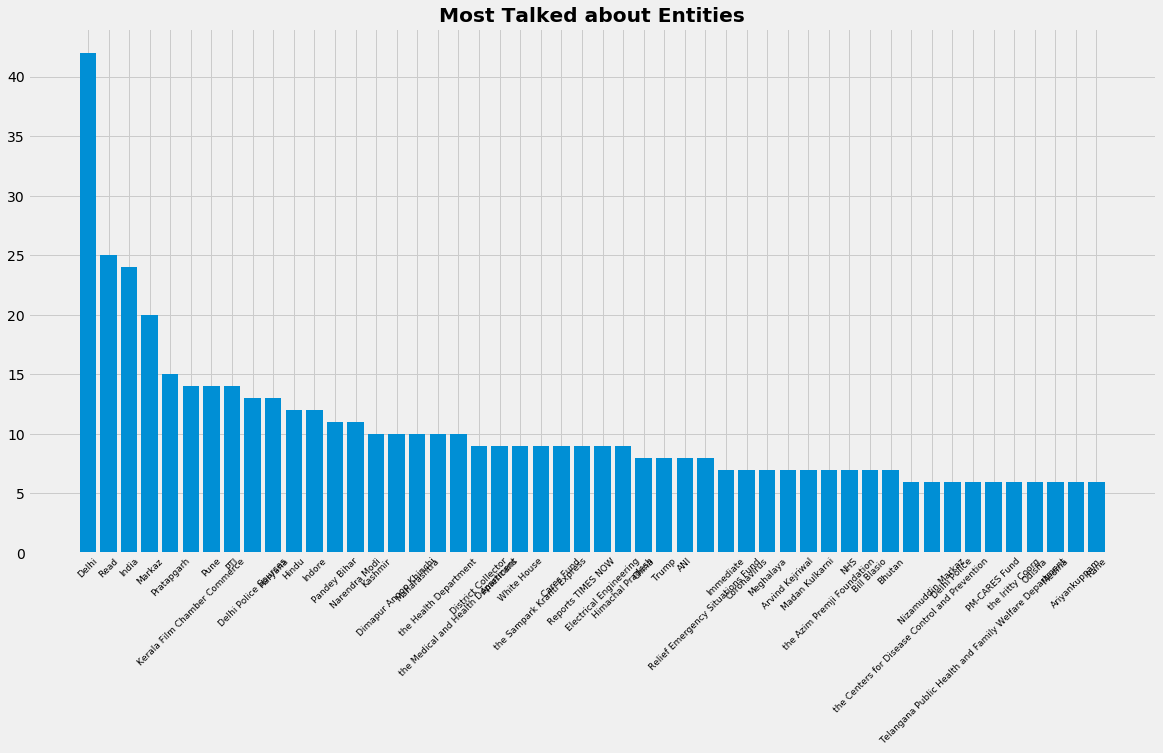

In [55]:
plt.figure(figsize=(18,9))
plt.xticks(rotation='45',fontsize = 9)
plt.bar(*zip(*entity_counts.most_common(50)))
plt.title(label = 'Most Talked about Entities',fontweight = 'bold')
plt.show()


#### Let's find some documents swith the Top enities that we found above

In [56]:
entity_filtered_docs = docs_for_pos[(docs_for_pos.cleaned_for_pos_tagging.str.contains('India')) 
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('WHO'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('FACT'))
                                    | ( docs_for_pos.cleaned_for_pos_tagging.str.contains('Maharastra'))]

In [57]:
entity_filtered_docs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 0 to 316
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   text                     49 non-null     object
 1   cleaned_text             49 non-null     object
 2   cleaned_for_pos_tagging  49 non-null     object
dtypes: object(3)
memory usage: 1.5+ KB


In [58]:
for  text in entity_filtered_docs.sample(10).text:
    test_doc = nlp(text)
    displacy.render(test_doc, style="ent")
    print('---------')

---------


---------


---------


---------


---------


---------


---------


---------


---------


---------


### Entity Relations using Knowledge Graph

We have to do some dependency parsing on the texts to find the Subjects and objects and find the ROOT word i.e. the dependency between them

In [59]:
# https://www.analyticsvidhya.com/blog/2019/10/how-to-build-knowledge-graph-text-using-spacy/?utm_source=blog&utm_medium=introduction-information-extraction-python-spacy

def get_entity_pairs(text):

    entity_1 = ''
    entity_2 = ''

    previous_dependency = ''
    previous_text = ''

    prefix = ''
    modifier = ''

    for token in nlp(text):
        if token.dep_ != 'punct':
            if token.dep_ == 'compound':
                prefix = previous_text + " "+ token.text

         # check: token is a modifier or not
        if token.dep_.endswith("mod") == True:
            modifier = token.text
        # if the previous word was also a 'compound' then add the current word to it
            if previous_dependency == "compound":
                  modifier = previous_text + " "+ token.text

      ## chunk 3
        if token.dep_.find("subj") == True:
            entity_1 = modifier +" "+ prefix + " "+ token.text
            prefix = ""
            modifier = ""
            previous_text = ""
            previous_dependency = ""      

      ## chunk 4
        if token.dep_.find("obj") == True:
            entity_2 = modifier +" "+ prefix +" "+ token.text

      ## chunk 5  
      # update variables
        prv_tok_dep = token.dep_
        prv_tok_text = token.text
  #############################################################
    return [entity_1.strip(), entity_2.strip()]

In [60]:
entity_pairs = [get_entity_pairs(text) for text in tqdm_notebook(entity_filtered_docs.text)]

In [61]:
entity_pairs[5:25]

[['yesterday  INS samples', 'Health plane'],
 ['second  issue', 'Covid patients'],
 ['Secretary  R Pompeo', 'today  State Department'],
 ['Indiabulls group', '21  CARES Fund'],
 ['24  Ministry', 'Family Tuesday'],
 ['where  acorss who', 'Tabligh Jamaat'],
 ['private  they', 'private  laboratories'],
 ['Death toll', '35'],
 ['unseen  WHO', 'unseen  place'],
 ['one  delivery sum', 'related  issues'],
 ['Tablighi who', 'visa'],
 ['dedicated  novel account', '#  handle'],
 ['incurs  trade losses', ''],
 ['medical  day 45', '62  Civil Aviation'],
 ['who', 'recent  visa India'],
 ['recent  visa Violators', 'recent  visa India'],
 ['there  TS Sandhu', 'US'],
 ['medical  Disease India', 'Singh US'],
 ['humanitarian  Mittal efforts', 'many  Indians'],
 ['@JSPLCorporate  Naveen gesture', 'Jindal  Naveen you']]

In [62]:
def get_relation(text):
    
    doc = nlp(text)
    matcher =  Matcher(nlp.vocab)
    
    pattern = [
                {'DEP' : 'ROOT'},
                {'DEP' : 'prep', 'OP': '?'},
                {'DEP' : 'agent','OP': '?'},
                {'POS' : 'ADJ','OP' : '?' }
              ]
    
    matcher.add('matching_1', None , pattern)
    matches = matcher(doc)
    k = len(matches) - 1
    
    span = doc[matches[k][1]:matches[k][2]]
    
    return(span.text)

In [63]:
entity_relations = [get_relation(text) for text in tqdm_notebook(entity_filtered_docs.text)]

In [64]:
Counter(entity_relations).most_common(10)

[('pledges', 3),
 ('seeks', 2),
 ('travel', 2),
 ('blacklisted', 2),
 ('IndiaFightsCorona', 2),
 ('said', 2),
 ('dies from', 1),
 ('carried by', 1),
 ('Read', 1),
 ('spoke with Indian', 1)]

In [65]:
def combine_entities_and_relations(entity_pairs , entity_relations):   
    entity_subjects = [i[0] for i in entity_pairs ]
    entity_objects  = [i[1] for i in entity_pairs ]

    entities_and_relations_df = pd.DataFrame({'subject': entity_subjects,
                                              'object' : entity_objects,
                                              'relation': entity_relations
                                             })

    entities_and_relations_df.drop_duplicates(subset=None, keep='first', inplace=True)
    
    return entities_and_relations_df

In [66]:
entities_and_relations_df = combine_entities_and_relations(entity_pairs , entity_relations)
entities_and_relations_df.relation.value_counts()

pledges              3
blacklisted          2
IndiaFightsCorona    2
said                 2
believes             1
driven by            1
Min                  1
asks                 1
1585657543000        1
recovered from       1
Modi                 1
operated by          1
Govt of              1
confirmed            1
locations            1
expected             1
says                 1
worth                1
Gangakhedkar         1
"                    1
be                   1
seeks                1
been                 1
's                   1
spoke with Indian    1
assured of           1
travel               1
committed            1
Sandhu               1
launches             1
advised              1
named                1
put                  1
dies from            1
railways             1
evaluated            1
Read                 1
carried by           1
envoy                1
said on              1
rises to             1
supply               1
Name: relation, dtype: int64

### Computing the Entity relation for the entire corpus

In [67]:
entity_pairs_for_all_data = [get_entity_pairs(text) for text in tqdm_notebook(docs_for_pos.text)]

In [68]:
entity_relations_for_all_data = [get_relation(text) for text in tqdm_notebook(docs_for_pos.text)]

In [69]:
entities_and_relations_all = combine_entities_and_relations(entity_pairs_for_all_data , entity_relations_for_all_data)
entities_and_relations_all.relation.value_counts()

said               24
Read                8
tested positive     7
reports             6
Arvind              5
                   ..
gather for          1
trying              1
man                 1
Limited             1
took                1
Name: relation, Length: 204, dtype: int64

In [70]:
def compute_and_plot_network(entities_and_relations_df , relation_text ):   
    network = nx.from_pandas_edgelist(entities_and_relations_df.loc[entities_and_relations_df.relation == relation_text],
                                      source= 'subject',
                                      target= 'object',
                                      edge_attr=True,
                                      create_using=nx.MultiDiGraph()
                                     )

    # Plot the network
    plt.figure(figsize=(14,6))
    pos = nx.spring_layout(network)
    nx.draw(network, 
            with_labels=True,
            arrows = True,
            font_size = 9,
            node_color='skyblue',
            edge_cmap=plt.cm.Blues,
            pos = pos,
           )
#     nx.draw_networkx_edge_labels(network, pos=pos)
#     labels=nx.draw_networkx_labels(network,pos=pos,font_size=7)
    plt.show()

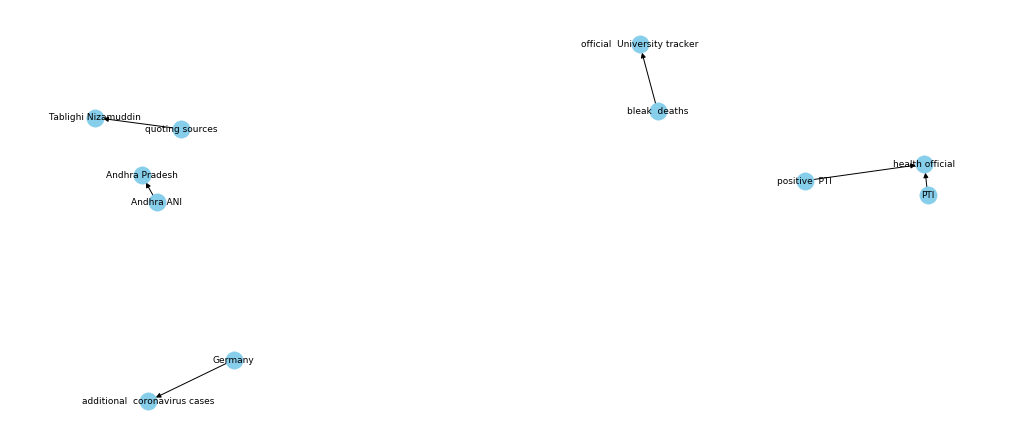

In [78]:
compute_and_plot_network(entities_and_relations_all,'reports')

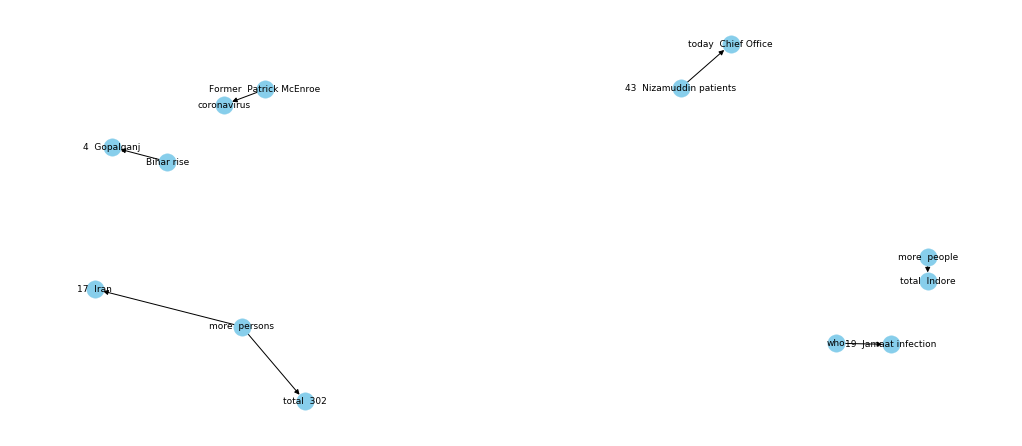

In [72]:
compute_and_plot_network(entities_and_relations_all,'tested positive')

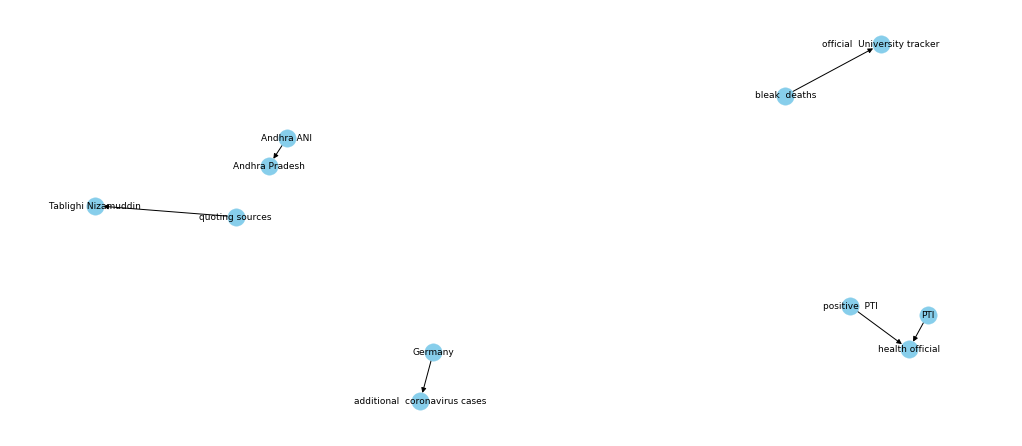

In [73]:
compute_and_plot_network(entities_and_relations_all,'reports')

In [63]:
documents.to_csv('../Data/all_documents_till_29th_March.csv',index=False)